# Feature extraction

This part of the course is about detecting features like edges, lines, circles, and blobs from images.

Many biological objects (cells, bacteria, bacilli, etc.) can be approximated by simple shapes and detected this way.

While deep learning approaches typically outperform the classical approaches presented here, they are still part of most image processing pipelines, and complement deep learning techniques either as pre-processing or post-processing.

Run the code making sure you understand the syntax. Complete the parts marked **TODO** either in the text or in the code.

Don't hesitate to re-use what you learned in previous notebooks (filtering, morphological operations etc) to improve your results!

## Setup

First, we need to import some packages so that their functions are available to us.

In [11]:
import os                       # operating system operations like file paths etc
import numpy as np              # multidimensional arrays, linear algebra
from skimage import io          # to load and save data
from skimage import color       # color conversion utilities
from skimage import segmentation
from skimage.util import invert   # invert an image (if binary, black->white, white->black)
from skimage.filters import threshold_otsu, sobel, sobel_v, sobel_h, laplace # image processing filters
from skimage.feature import canny # edge detector

from skimage.transform import hough_circle, hough_circle_peaks, hough_line, hough_line_peaks # Hough transform
from skimage.feature import blob_log # Laplacian of Gaussian

import matplotlib.pyplot as plt # plotting


path_to_images= './data'    # Local: where the images are relative to this notebook
#path_to_images= os.path.join('Module2','data')    # Nuvolos: where the images are relative to this notebook

## Data loading and exploration

Let's start with our previous neuroblastoma image.

Image has shape (512, 640)


Text(0.5, 1.0, 'Original image')

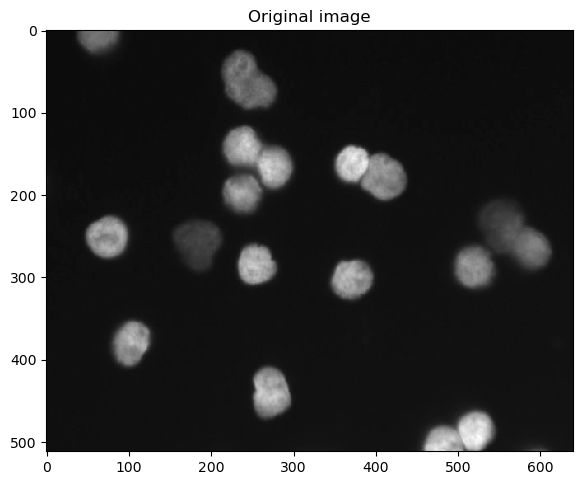

In [12]:
# Load and normalize the neuroblastoma image
image_file = os.path.join(path_to_images, 'neuroblastoma_5_orig_small.jpg')
img = io.imread(image_file)
img = img/np.max(img) # normalize the image to [0,1]
print(f'Image has shape {img.shape}')

# Display the image
plt.figure()
io.imshow(img)
plt.title('Original image')

## First order approaches

### Edge detection

Edge detections allows us to find regions of the image with sharp contrast, that is where dark rapidly becomes bright and vice-versa. These edges may not correspond to human perception.

#### Sobel operator

A basic approach is to use a Sobel operator, open and read the documentation in scikit-image
- <https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.sobel>

We briefly show its appearance since it is helpful in understanding the practical implementation of the Canny edge detector.

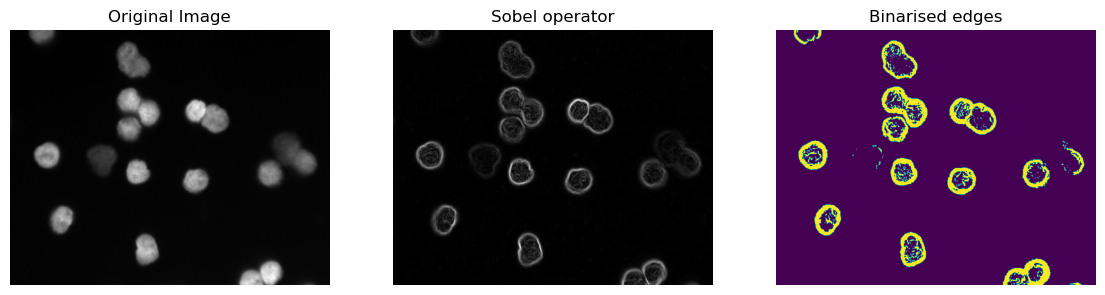

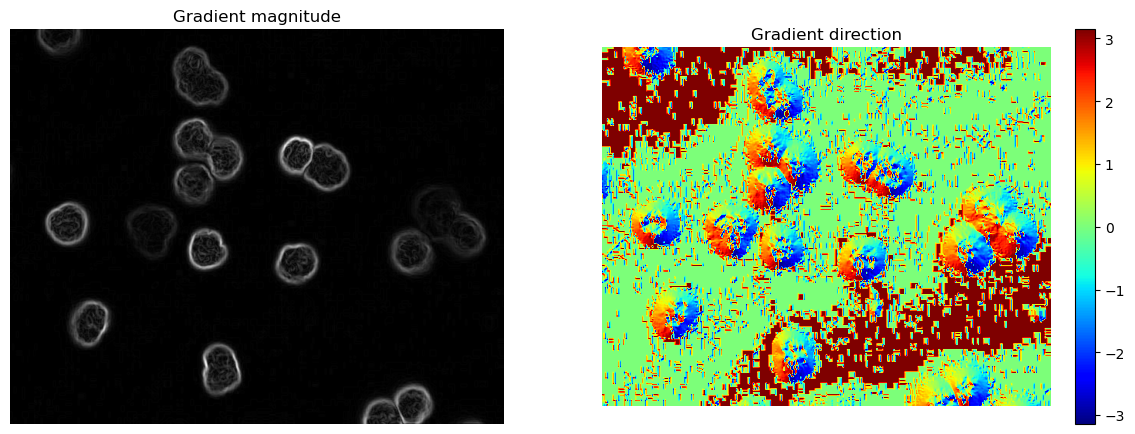

In [13]:
""" 
Sobel operator on neuroblastoma image
"""

# Detect edges using Sobel operator edge detector
edges_sobel = sobel(img)

# threshold the edges map with Otsu's method
thresh = threshold_otsu(edges_sobel)
edges_sobel_bin = edges_sobel > thresh

# Display the original image, the Sobel the detected edges side by side
fig, axes = plt.subplots(1, 3, figsize=(14, 7))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(edges_sobel, cmap='gray')
axes[1].set_title('Sobel operator')
axes[1].axis('off')
axes[2].imshow(edges_sobel_bin)
axes[2].set_title('Binarised edges')
axes[2].axis('off')

plt.show()


# compute gradient magnitude and direction
edges_sobel_h = sobel_h(img)
edges_sobel_v = sobel_v(img)
grad_mag = np.sqrt(edges_sobel_h**2 + edges_sobel_v**2) # same as sobel(img)
grad_dir = np.arctan2(edges_sobel_v,edges_sobel_h) # angle in radians

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(grad_mag, cmap='gray')
axes[0].set_title('Gradient magnitude')
axes[0].axis('off')
axes[1].imshow(grad_dir, cmap='hot')
axes[1].set_title('Gradient direction')
axes[1].axis('off')

fig.colorbar(axes[1].imshow(grad_dir, cmap='jet'), ax=axes[1],fraction=0.04, pad=0.05)




#### Canny edge detector

An improved approach and commonly used algorithm is the Canny detector, open and read the documentation in scikit-image
- <https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny>

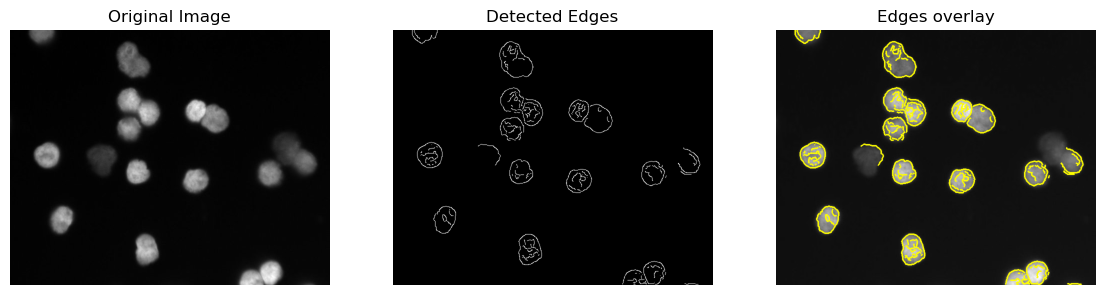

In [14]:
""" 
Edge detection for neuroblastoma image
"""

# Detect edges using Canny edge detector
edges = canny(img, sigma=1.0, low_threshold=0.1, high_threshold=0.2)

# create an overlay of the edges on the original image
edges_overlay = segmentation.mark_boundaries(img, np.array(edges,dtype=np.uint8), mode='thick')

# Display the original image and the detected edges side by side
fig, axes = plt.subplots(1, 3, figsize=(14, 7))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(edges, cmap='gray')
axes[1].set_title('Detected Edges')
axes[1].axis('off')
axes[2].imshow(edges_overlay)
axes[2].set_title('Edges overlay')
axes[2].axis('off')

plt.show()





**TODO** Experiment with the smoothing kernel size (Gaussian filter standard deviation), modifying from the default value of 1. try 0.5, 2, 3... what yields the best results according to you?

**TODO** Also experiment with the high and low thresholds.

Keep these settings as we will use your edges below to try and locate circles.

## Second order approaches

### Laplacian operator

This is simply an approximation to the second derivative (change of change) of the image. Here we just show results with no experimentation because the Laplacian filter on it's own does not work very well for edge detection.


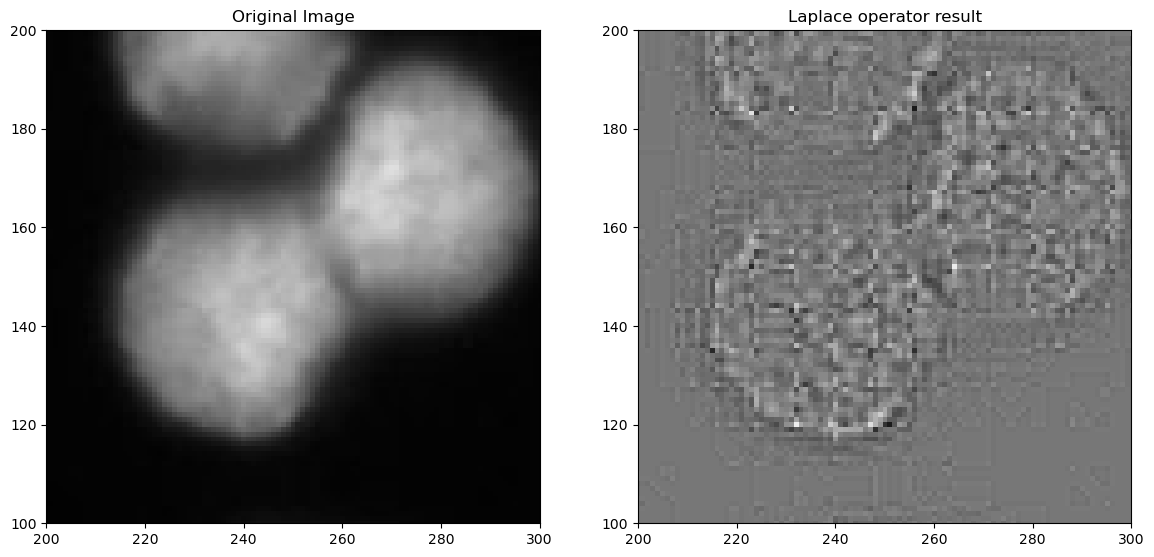

In [15]:
# Load and normalize the neuroblastoma image
image_file = os.path.join(path_to_images, 'neuroblastoma_5_orig_small.jpg')
img = io.imread(image_file)
img = img/np.max(img) # normalize the image to [0,1]

edges_laplace = laplace(img, ksize=5)


fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].set_xlim((200,300))
axes[0].set_ylim((100,200))
axes[1].imshow(edges_laplace, cmap='gray')
axes[1].set_title('Laplace operator result')
axes[1].set_xlim((200,300))
axes[1].set_ylim((100,200))


plt.show()

As you can see, the results are very noisy and not usable directly.

### Laplacian of Gaussian (LoG)

This operator, also called Marr-Hildreth or Mexican Hat operator (due to its shape in 3D) combines Gaussian smoothing and the Laplace operator.

Open and read the doc:
- <https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.blob_log>

Image has shape (512, 640)
Detected 14 blobs


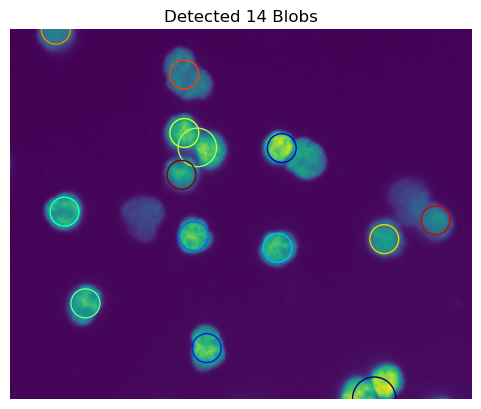

In [16]:
"""
LoG for blob detection in neuroblastoma image
"""

# Load and normalize the neuroblastoma image
image_file = os.path.join(path_to_images, 'neuroblastoma_5_orig_small.jpg')
img = io.imread(image_file)
img = img/np.max(img) # normalize the image to [0,1]
print(f'Image has shape {img.shape}')

# Define the range of blob sizes to detect
min_sigma = 20
max_sigma = 50

# Perform blob detection using LoG
blobs = blob_log(img, min_sigma=min_sigma, max_sigma=max_sigma, threshold_rel=0.2, overlap=0.7)
n_blobs = blobs.shape[0]
print(f'Detected {n_blobs} blobs')

# Display the detected blobs
cm=plt.cm.jet # get a colormap
fig, ax = plt.subplots()
ax.imshow(img)

for i, blob in enumerate(blobs):
    y, x, radius = blob
    circle = plt.Circle((x, y), radius, color=cm(i/(n_blobs-1)), fill=False)
    ax.add_patch(circle)

plt.title(f'Detected {n_blobs} Blobs')
plt.axis('off')
plt.show()


**TODO** try to optimize the parameters of the LoG blob detector - including `min_sigma` and `max_sigma`, `threshold_rel`, and `overlap`.

Can you get close to your estimate of the ground truth of the number of cells?

## Hough transform

The Hough transform is a fast and efficient approach to detecting lines, circles, and ellipses. 

It works well when the image is relatively noise-free, which is why we often run it on edge images.

### Hough transform for circles

Here we can approximate cells by circles, and we would like to localise each individual cell.

Open and read the scikit-image documentation for these two functions:
- <https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.hough_circle>
- <https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.hough_circle_peaks>

Detected 20 circles


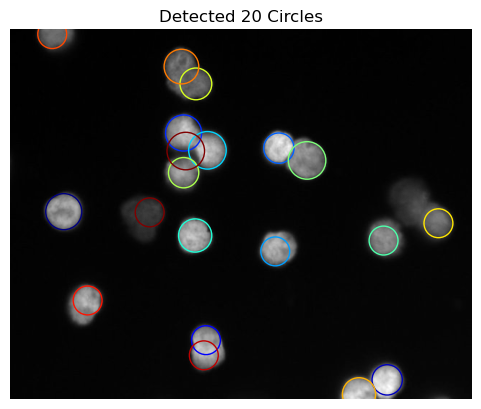

In [17]:
""" 
Hough transform for circle for cell detection in neuroblastoma image
"""

# Define the range of radii to search for circles
# This is a great way to input domain knowledge - how big are the cells you want to find (in pixels)?
# Refer to the first visualisation of the image which has axis ticks to get an idea of the size of the cells
min_radius = 20
max_radius = 50

# define the separation between circles - how far apart are cells (in pixels)?
# Refer to the first visualisation of the image which has axis ticks to get an idea of the separation of the cells
min_xdistance=20
min_ydistance=20

# Apply the Hough transform on the edges image to detect circles
hough_radii = np.arange(min_radius, max_radius + 1)
hough_res = hough_circle(edges, hough_radii)

# Find the most prominent circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                           min_xdistance=min_xdistance, min_ydistance=min_ydistance,
                                           total_num_peaks=20)
n_circles=radii.shape[0]
print(f'Detected {n_circles} circles')


# Display the original image with detected circles in different colors
cm=plt.cm.jet # get a colormap
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')

for i, (center_y, center_x, radius) in enumerate(zip(cy, cx, radii)):
    circle = plt.Circle((center_x, center_y), radius, color=cm(i/(n_circles-2)), fill=False)
    ax.add_patch(circle)

plt.title(f'Detected {n_circles} Circles')
plt.axis('off')
plt.show()


**TODO** Experiment with cell sizes (`min_radius`, `max_radius`), cell separation (`min_xdistance`,`min_ydistance`) and max number of peaks (`total_num_peaks`), 
Can you get all cells detected (high true positive rate), and only one circle per cell (low false positive rate) ? 

Remember that you are operating on the Canny edge image, so you may need to revisit the Gaussian filter standard deviation above.

### Hough transform for lines

Here we are trying to approximately count the number of gram-positive bacilli from a gram staining image. Since the bacilli are linear, we can look for lines in the image using a Hough transform. 

Note that this approach is for didactic purposes, there are better methods to perform this kind of analysis.

We will use the scikit-image implementation. The two functions you need (read the docs!) are
- <https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.hough_line>
- <https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.hough_line_peaks>

Image has shape (308, 338)


Text(0.5, 1.0, 'Original image')

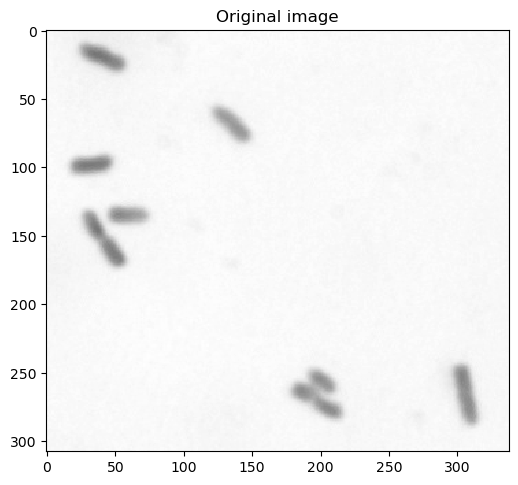

In [18]:
# Load and normalize the Gram stain image
image_file = os.path.join(path_to_images, 'gram_negative_bacilli_crop.png')
img = io.imread(image_file)
img = color.rgb2gray(img) # convert to grayscale
img = img/np.max(img) # normalize the image to [0,1]
print(f'Image has shape {img.shape}')

# Display the image
plt.figure()
io.imshow(img)

plt.title('Original image')

Found 10 lines


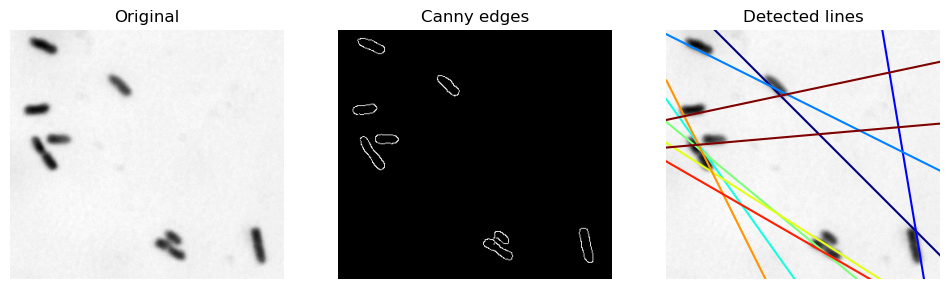

In [19]:
"""
Line Hough transform to detect bacilli (adapted from skimage doc)
"""

# First detect edges to make our life easier - Hough transform is sensitive to noise
edges=canny(img, sigma=1)

# Define the range of angles to search for lines. If we have a priori information about the orientation of the lines
# we are interested in, we could restrict the search range
search_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)

# Run the Hough transform
houghspace, houghangles, houghdistances = hough_line(edges, theta=search_angles)

# Find the most prominent lines
peaks = hough_line_peaks(houghspace, houghangles, houghdistances, min_distance=20,min_angle=20)
n_peaks=len(peaks[0])
print(f'Found {n_peaks} lines')

# Overlay the detected lines on the image
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
ax = axes.ravel()

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')
ax[0].set_axis_off()

ax[1].imshow(edges, cmap='gray')
ax[1].set_title('Canny edges')
ax[1].set_axis_off()

ax[2].imshow(img,cmap='gray')
ax[2].set_xlim((0,img.shape[1]))
ax[2].set_ylim((img.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

for i, (_, angle, dist) in enumerate(zip(*peaks)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi / 2), color=cm(i/(n_peaks-2)))

plt.show()


Your goal is to get a count of the bacilli. The true value is probably 8. Here we approximate the number of bacilli found by the number of lines detected. Again, this is not a robust approach in real life.


**TODO** Play with the `min_distance` and `min_angle` of the `hough_line_peaks` function. Can you improve upon the initial setting of 20 and 20? 

**TODO** Play with the Canny edge detector parameters, in particular Gaussian filter standard deviation. What gives you the cleanest edges?

**TODO** What is the impact of the resolution of the search angles?

**TODO** The two bacilli in the south-west corner of the image have a thinner midsection. Can you run morphological operations to try and fill them ? Does that improve or worsen the Hough transform results?

**TODO** Write down your best solution in terms of Canny edge detection parameters, parameters for `hough_line_peaks`, search angle resolution, possibly morphological operations.

# BONUS Material

Only do this if you have time

## Approximating the LoG by a Difference of Gaussian

We can approximage LoG by a first-order operator, the DoG. In skimage this is in `filters.difference_of_gaussians`

-<https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.difference_of_gaussians>

Image has shape (512, 640)


(100.0, 200.0)

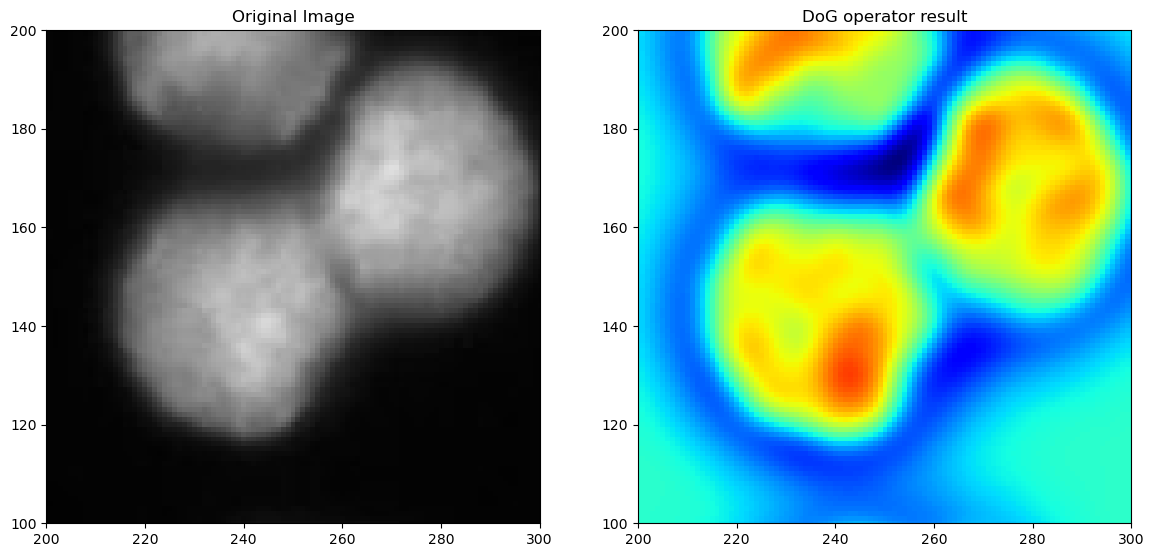

In [20]:
"""
DoG approximation to the LoG
"""

from skimage.filters import difference_of_gaussians

# Load and normalize the neuroblastoma image
image_file = os.path.join(path_to_images, 'neuroblastoma_5_orig_small.jpg')
img = io.imread(image_file)
img = img/np.max(img) # normalize the image to [0,1]
print(f'Image has shape {img.shape}')

filtered_image = difference_of_gaussians(img, low_sigma=3, high_sigma=10)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].set_xlim((200,300))
axes[0].set_ylim((100,200))
axes[1].imshow(filtered_image, cmap='jet')
axes[1].set_title('DoG operator result')
axes[1].set_xlim((200,300))
axes[1].set_ylim((100,200))
